# Packages

In [1]:
! pip install numba 


[notice] A new release of pip is available: 23.0.1 -> 25.1
[notice] To update, run: pip install --upgrade pip


In [2]:
pip install scikit-learn shap


[notice] A new release of pip is available: 23.0.1 -> 25.1
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [3]:
import time

import numba
import numpy as np
import sklearn.ensemble

import shap

/Users/gillesfevry/.pyenv/versions/3.10.12/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [4]:
import matplotlib.pyplot as plt
from sksurv.datasets import load_whas500
from sksurv.ensemble import RandomSurvivalForest
from sklearn.model_selection import train_test_split
from lifelines import KaplanMeierFitter
import numpy as np
import itertools
import random
from survinsights import local_explaination
from survinsights.explainer import explainer
from tqdm import tqdm

# Fonction

In [5]:
#au t-ième moment 

class TreeExplainer:
    def __init__(self, model, t=0, **kwargs):
        if str(type(model)).endswith("sklearn.ensemble._forest.RandomForestRegressor'>") or 1==1: #attention
            # self.trees = [Tree(e.tree_) for e in model.estimators_]
            self.trees = [
                Tree(
                    children_left=e.tree_.children_left,
                    children_right=e.tree_.children_right,
                    children_default=e.tree_.children_right,
                    feature=e.tree_.feature,
                    threshold=e.tree_.threshold,
                    value=e.tree_.value[:, t, 1],
                    node_sample_weight=e.tree_.weighted_n_node_samples,
                )
                for e in model.estimators_
            ]

        # Preallocate space for the unique path data
        maxd = np.max([t.max_depth for t in self.trees]) + 2
        s = (maxd * (maxd + 1)) // 2
        self.feature_indexes = np.zeros(s, dtype=np.int32)
        self.zero_fractions = np.zeros(s, dtype=np.float64)
        self.one_fractions = np.zeros(s, dtype=np.float64)
        self.pweights = np.zeros(s, dtype=np.float64)

    def shap_values(self, X, **kwargs):
        # convert dataframes
        if str(type(X)).endswith("pandas.core.series.Series'>"):
            X = X.values
        elif str(type(X)).endswith("'pandas.core.frame.DataFrame'>"):
            X = X.values

        assert str(type(X)).endswith("'numpy.ndarray'>"), "Unknown instance type: " + str(type(X))
        assert len(X.shape) == 1 or len(X.shape) == 2, "Instance must have 1 or 2 dimensions!"

        # single instance
        if len(X.shape) == 1:
            phi = np.zeros(X.shape[0] + 1)
            x_missing = np.zeros(X.shape[0], dtype=bool)
            for t in self.trees:
                self.tree_shap(t, X, x_missing, phi)
            phi /= len(self.trees)
        elif len(X.shape) == 2:
            phi = np.zeros((X.shape[0], X.shape[1] + 1))
            x_missing = np.zeros(X.shape[1], dtype=bool)
            for i in range(X.shape[0]):
                for t in self.trees:
                    self.tree_shap(t, X[i, :], x_missing, phi[i, :])
            phi /= len(self.trees)
        return phi

    def tree_shap(self, tree, x, x_missing, phi, condition=0, condition_feature=0):
        # update the bias term, which is the last index in phi
        # (note the paper has this as phi_0 instead of phi_M)
        if condition == 0:
            phi[-1] += tree.values[0]

        # start the recursive algorithm
        tree_shap_recursive(
            tree.children_left,
            tree.children_right,
            tree.children_default,
            tree.features,
            tree.thresholds,
            tree.values,
            tree.node_sample_weight,
            x,
            x_missing,
            phi,
            0,
            0,
            self.feature_indexes,
            self.zero_fractions,
            self.one_fractions,
            self.pweights,
            1,
            1,
            -1,
            condition,
            condition_feature,
            1,
        )

In [6]:
# extend our decision path with a fraction of one and zero extensions
@numba.jit(
    numba.types.void(
        numba.types.int32[:],
        numba.types.float64[:],
        numba.types.float64[:],
        numba.types.float64[:],
        numba.types.int32,
        numba.types.float64,
        numba.types.float64,
        numba.types.int32,
    ),
    nopython=True,
    nogil=True,
)
def extend_path(
    feature_indexes,
    zero_fractions,
    one_fractions,
    pweights,
    unique_depth,
    zero_fraction,
    one_fraction,
    feature_index,
):
    feature_indexes[unique_depth] = feature_index
    zero_fractions[unique_depth] = zero_fraction
    one_fractions[unique_depth] = one_fraction
    if unique_depth == 0:
        pweights[unique_depth] = 1
    else:
        pweights[unique_depth] = 0

    for i in range(unique_depth - 1, -1, -1):
        pweights[i + 1] += one_fraction * pweights[i] * (i + 1) / (unique_depth + 1)
        pweights[i] = zero_fraction * pweights[i] * (unique_depth - i) / (unique_depth + 1)


# undo a previous extension of the decision path
@numba.jit(
    numba.types.void(
        numba.types.int32[:],
        numba.types.float64[:],
        numba.types.float64[:],
        numba.types.float64[:],
        numba.types.int32,
        numba.types.int32,
    ),
    nopython=True,
    nogil=True,
)
def unwind_path(feature_indexes, zero_fractions, one_fractions, pweights, unique_depth, path_index):
    one_fraction = one_fractions[path_index]
    zero_fraction = zero_fractions[path_index]
    next_one_portion = pweights[unique_depth]

    for i in range(unique_depth - 1, -1, -1):
        if one_fraction != 0:
            tmp = pweights[i]
            pweights[i] = next_one_portion * (unique_depth + 1) / ((i + 1) * one_fraction)
            next_one_portion = tmp - pweights[i] * zero_fraction * (unique_depth - i) / (unique_depth + 1)
        else:
            pweights[i] = (pweights[i] * (unique_depth + 1)) / (zero_fraction * (unique_depth - i))

    for i in range(path_index, unique_depth):
        feature_indexes[i] = feature_indexes[i + 1]
        zero_fractions[i] = zero_fractions[i + 1]
        one_fractions[i] = one_fractions[i + 1]


# determine what the total permuation weight would be if
# we unwound a previous extension in the decision path
@numba.jit(
    numba.types.float64(
        numba.types.int32[:],
        numba.types.float64[:],
        numba.types.float64[:],
        numba.types.float64[:],
        numba.types.int32,
        numba.types.int32,
    ),
    nopython=True,
    nogil=True,
)
def unwound_path_sum(feature_indexes, zero_fractions, one_fractions, pweights, unique_depth, path_index):
    one_fraction = one_fractions[path_index]
    zero_fraction = zero_fractions[path_index]
    next_one_portion = pweights[unique_depth]
    total = 0

    for i in range(unique_depth - 1, -1, -1):
        if one_fraction != 0:
            tmp = next_one_portion * (unique_depth + 1) / ((i + 1) * one_fraction)
            total += tmp
            next_one_portion = pweights[i] - tmp * zero_fraction * ((unique_depth - i) / (unique_depth + 1))
        else:
            total += (pweights[i] / zero_fraction) / ((unique_depth - i) / (unique_depth + 1))

    return total


class Tree:
    def __init__(
        self,
        children_left,
        children_right,
        children_default,
        feature,
        threshold,
        value,
        node_sample_weight,
    ):
        self.children_left = children_left.astype(np.int32)
        self.children_right = children_right.astype(np.int32)
        self.children_default = children_default.astype(np.int32)
        self.features = feature.astype(np.int32)
        self.thresholds = threshold
        self.values = value
        self.node_sample_weight = node_sample_weight

        self.max_depth = compute_expectations(
            self.children_left,
            self.children_right,
            self.node_sample_weight,
            self.values,
            0,
        )


@numba.jit(nopython=True)
def compute_expectations(children_left, children_right, node_sample_weight, values, i, depth=0):
    if children_right[i] == -1:
        values[i] = values[i]
        return 0
    else:
        li = children_left[i]
        ri = children_right[i]
        depth_left = compute_expectations(children_left, children_right, node_sample_weight, values, li, depth + 1)
        depth_right = compute_expectations(children_left, children_right, node_sample_weight, values, ri, depth + 1)
        left_weight = node_sample_weight[li]
        right_weight = node_sample_weight[ri]
        v = (left_weight * values[li] + right_weight * values[ri]) / (left_weight + right_weight)
        values[i] = v
        return max(depth_left, depth_right) + 1


# recursive computation of SHAP values for a decision tree
@numba.jit(
    numba.types.void(
        numba.types.int32[:],
        numba.types.int32[:],
        numba.types.int32[:],
        numba.types.int32[:],
        numba.types.float64[:],
        numba.types.float64[:],
        numba.types.float64[:],
        numba.types.float64[:],
        numba.types.boolean[:],
        numba.types.float64[:],
        numba.types.int64,
        numba.types.int64,
        numba.types.int32[:],
        numba.types.float64[:],
        numba.types.float64[:],
        numba.types.float64[:],
        numba.types.float64,
        numba.types.float64,
        numba.types.int64,
        numba.types.int64,
        numba.types.int64,
        numba.types.float64,
    ),
    nopython=True,
    nogil=True,
)
def tree_shap_recursive(
    children_left,
    children_right,
    children_default,
    features,
    thresholds,
    values,
    node_sample_weight,
    x,
    x_missing,
    phi,
    node_index,
    unique_depth,
    parent_feature_indexes,
    parent_zero_fractions,
    parent_one_fractions,
    parent_pweights,
    parent_zero_fraction,
    parent_one_fraction,
    parent_feature_index,
    condition,
    condition_feature,
    condition_fraction,
):
    # stop if we have no weight coming down to us
    if condition_fraction == 0:
        return

    # extend the unique path
    feature_indexes = parent_feature_indexes[unique_depth + 1 :]
    feature_indexes[: unique_depth + 1] = parent_feature_indexes[: unique_depth + 1]
    zero_fractions = parent_zero_fractions[unique_depth + 1 :]
    zero_fractions[: unique_depth + 1] = parent_zero_fractions[: unique_depth + 1]
    one_fractions = parent_one_fractions[unique_depth + 1 :]
    one_fractions[: unique_depth + 1] = parent_one_fractions[: unique_depth + 1]
    pweights = parent_pweights[unique_depth + 1 :]
    pweights[: unique_depth + 1] = parent_pweights[: unique_depth + 1]

    if condition == 0 or condition_feature != parent_feature_index:
        extend_path(
            feature_indexes,
            zero_fractions,
            one_fractions,
            pweights,
            unique_depth,
            parent_zero_fraction,
            parent_one_fraction,
            parent_feature_index,
        )

    split_index = features[node_index]

    # leaf node
    if children_right[node_index] == -1:
        for i in range(1, unique_depth + 1):
            w = unwound_path_sum(
                feature_indexes,
                zero_fractions,
                one_fractions,
                pweights,
                unique_depth,
                i,
            )
            phi[feature_indexes[i]] += (
                w * (one_fractions[i] - zero_fractions[i]) * values[node_index] * condition_fraction
            )

    # internal node
    else:
        # find which branch is "hot" (meaning x would follow it)
        hot_index = 0
        cleft = children_left[node_index]
        cright = children_right[node_index]
        if x_missing[split_index] == 1:
            hot_index = children_default[node_index]
        elif x[split_index] < thresholds[node_index]:
            hot_index = cleft
        else:
            hot_index = cright
        cold_index = cright if hot_index == cleft else cleft
        w = node_sample_weight[node_index]
        hot_zero_fraction = node_sample_weight[hot_index] / w
        cold_zero_fraction = node_sample_weight[cold_index] / w
        incoming_zero_fraction = 1
        incoming_one_fraction = 1

        # see if we have already split on this feature,
        # if so we undo that split so we can redo it for this node
        path_index = 0
        while path_index <= unique_depth:
            if feature_indexes[path_index] == split_index:
                break
            path_index += 1

        if path_index != unique_depth + 1:
            incoming_zero_fraction = zero_fractions[path_index]
            incoming_one_fraction = one_fractions[path_index]
            unwind_path(
                feature_indexes,
                zero_fractions,
                one_fractions,
                pweights,
                unique_depth,
                path_index,
            )
            unique_depth -= 1

        # divide up the condition_fraction among the recursive calls
        hot_condition_fraction = condition_fraction
        cold_condition_fraction = condition_fraction
        if condition > 0 and split_index == condition_feature:
            cold_condition_fraction = 0
            unique_depth -= 1
        elif condition < 0 and split_index == condition_feature:
            hot_condition_fraction *= hot_zero_fraction
            cold_condition_fraction *= cold_zero_fraction
            unique_depth -= 1

        tree_shap_recursive(
            children_left,
            children_right,
            children_default,
            features,
            thresholds,
            values,
            node_sample_weight,
            x,
            x_missing,
            phi,
            hot_index,
            unique_depth + 1,
            feature_indexes,
            zero_fractions,
            one_fractions,
            pweights,
            hot_zero_fraction * incoming_zero_fraction,
            incoming_one_fraction,
            split_index,
            condition,
            condition_feature,
            hot_condition_fraction,
        )

        tree_shap_recursive(
            children_left,
            children_right,
            children_default,
            features,
            thresholds,
            values,
            node_sample_weight,
            x,
            x_missing,
            phi,
            cold_index,
            unique_depth + 1,
            feature_indexes,
            zero_fractions,
            one_fractions,
            pweights,
            cold_zero_fraction * incoming_zero_fraction,
            0,
            split_index,
            condition,
            condition_feature,
            cold_condition_fraction,
        )

# RSF

In [7]:
X, y = load_whas500()
X = X.astype(float)
X = X.iloc[:, :4]#pour que le normal tourne
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [8]:
rsf = RandomSurvivalForest(random_state=42).fit(X_train, y_train)

# Comparaison

In [9]:
ex = TreeExplainer(rsf)

In [10]:
ex.shap_values(X_test.iloc[0, :])

array([1.48017690e-03, 1.40266435e-02, 6.39916100e-04, 1.49210337e-03,
       9.82125000e-01])

In [11]:
X_test.iloc[1, :]

afb     0.00000
age    77.00000
av3     0.00000
bmi    24.87489
Name: 73, dtype: float64

In [12]:
eval_times = rsf.estimators_[0].unique_times_
#eval_times = list(range(0,200,10))
model_explainer = explainer(rsf, X_test, y_test, 
                             times=eval_times)

In [13]:
#SurvSHAP_df = local_explaination.survshap(model_explainer, X_test, sample_id=1)

In [14]:
#local_explaination.plot_survshap(SurvSHAP_df)

/var/folders/9l/n7yv83fn1l5_xstw36wkw_3m0000gn/T/ipykernel_82586/1510433576.py:17: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


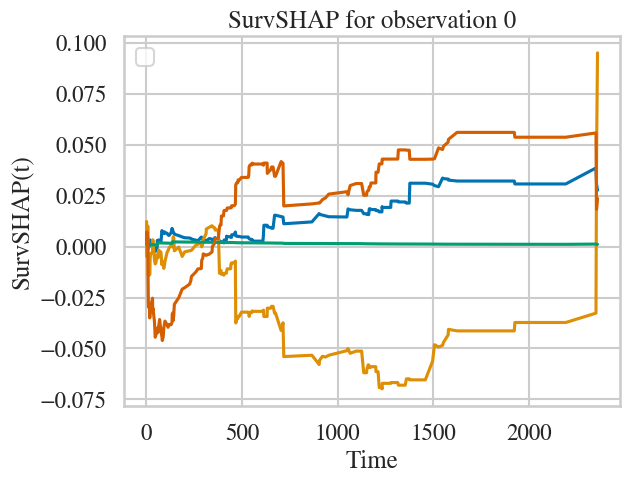

In [15]:
#écris pas éficacement
x=[]
y=[]
for i,t in enumerate(rsf.estimators_[0].unique_times_):
    ex = TreeExplainer(rsf,t=i)
    valeurs = ex.shap_values(X_test.iloc[1, :])[:-1]
    x.append(t)
    y.append(valeurs)

plt.plot(x, y)

# Ajouter des labels et une légende
#plt.xlim(0, 200)
plt.xlabel("Time")
plt.ylabel("SurvSHAP(t)")
plt.title("SurvSHAP for observation 0")
plt.legend()

# Afficher le graphique
plt.show()
    

In [16]:
import fonctions_SurvTreeShap as fstp

100%|██████████| 324/324 [00:00<00:00, 331.61it/s]


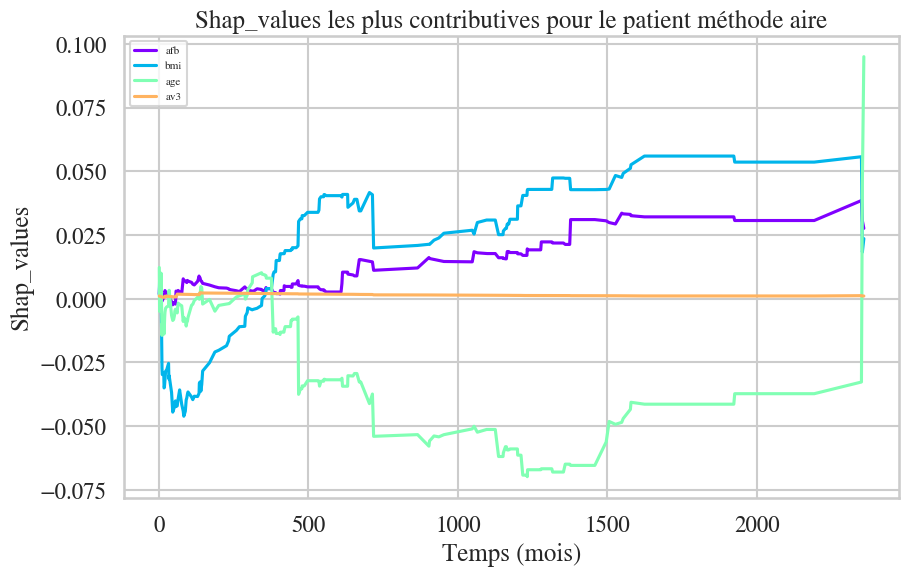

In [17]:
x_,y_ = fstp.Shapvalues(model= rsf, data=X_test.iloc[1, :], times=None)
fstp.STP_graph(x=x_, y=y_, columns=list(X.columns), selection="area", min=2, max=2)

# Graphiques temporels

In [18]:
def Comparaison_var_fixes(n=0):
    
    eval_times = list(range(n))
    model_explainer = explainer(rsf, X_test, y_test, times=eval_times)

    start=time.time()
    SurvSHAP_df = local_explaination.survshap(model_explainer, X_test, sample_id=0)
    total_shap=start-time.time()

    start=time.time()
    for i in range(len(eval_times)):
        TreeExplainer(rsf,t=i).shap_values(X_test.iloc[0, :])[:-1]
    total_survshap=start-time.time()

    return(-total_shap,-total_survshap)

In [19]:
Comparaison_var_fixes(n=2)

/Users/gillesfevry/.pyenv/versions/3.10.12/lib/python3.10/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RandomSurvivalForest was fitted with feature names
  warnings.warn(
  0%|          | 0/1 [00:00<?, ?it/s]/Users/gillesfevry/.pyenv/versions/3.10.12/lib/python3.10/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RandomSurvivalForest was fitted with feature names
  warnings.warn(
/Users/gillesfevry/.pyenv/versions/3.10.12/lib/python3.10/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RandomSurvivalForest was fitted with feature names
  warnings.warn(
100%|██████████| 1/1 [00:00<00:00,  1.29it/s]


(0.888401985168457, 0.005233049392700195)

In [20]:
def Nb_var_fixes(temps=1):
    x=np.array([i+1 for i in range(temps)])
    y=np.array([Comparaison_var_fixes(n=i+1) for i in range(temps)])
    y_kernel=y[:,0]
    y_tree=y[:,1]

    a, b = np.polyfit(x, y_kernel, 1)
    x_fit = np.linspace(min(x), max(x), 100)
    y_fit = a * x_fit + b
    plt.scatter(x, y_kernel, color='blue', label="Kernel")
    plt.plot(x_fit, y_fit, color='blue', label=f"y = {a:.2f}x + {b:.2f}")

    a, b = np.polyfit(x, y_tree, 1)
    x_fit = np.linspace(min(x), max(x), 100)
    y_fit = a * x_fit + b
    plt.scatter(x, y_tree, color='green', label="Tree")
    plt.plot(x_fit, y_fit, color='green', label=f"y = {a:.2f}x + {b:.2f}")

    plt.xlabel("Nombre de temps calculés ")
    plt.ylabel("Temps d'exécution")
    plt.legend()
    plt.title("Temps d'exécution des deux versions de shap selon le nombre de temps calculés pour une RSF à 4 variables.")
    plt.grid()
    plt.show()


In [21]:
Nb_var_fixes(temps=30)

/Users/gillesfevry/.pyenv/versions/3.10.12/lib/python3.10/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RandomSurvivalForest was fitted with feature names
  warnings.warn(
  0%|          | 0/1 [00:00<?, ?it/s]/Users/gillesfevry/.pyenv/versions/3.10.12/lib/python3.10/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RandomSurvivalForest was fitted with feature names
  warnings.warn(
/Users/gillesfevry/.pyenv/versions/3.10.12/lib/python3.10/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RandomSurvivalForest was fitted with feature names
  warnings.warn(
100%|██████████| 1/1 [00:00<00:00,  2.18it/s]
/Users/gillesfevry/.pyenv/versions/3.10.12/lib/python3.10/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RandomSurvivalForest was fitted with feature names
  warnings.warn(
  0%|

KeyboardInterrupt: 

In [ ]:
def graph_var(n):
    y_kernel=[]
    y_tree=[]
    t=[]
    for i in tqdm(range(n)):
        X, y = load_whas500()
        X = X.astype(float)
        X = X.iloc[:, :i+1]
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
        rsf = RandomSurvivalForest(random_state=42).fit(X_train, y_train)

        model_explainer = explainer(rsf, X_test, y_test, times=[1])
        start=time.time()
        SurvSHAP_df = local_explaination.survshap(model_explainer, X_test, sample_id=0)
        y_kernel.append(time.time()-start)

        start=time.time()
        TreeExplainer(rsf,t=1).shap_values(X_test.iloc[0, :])[:-1]
        y_tree.append(time.time()-start)
        t.append(i)

    log_y_kernel=np.log(np.array(y_kernel))
    a, b = np.polyfit(t, log_y_kernel, 1)
    x_fit = np.linspace(min(t), max(t), 100)
    y_fit = np.exp(b) * (np.exp(a)**x_fit)
    plt.scatter(t, y_kernel, color='blue', label="Kernel")
    plt.plot(x_fit, y_fit, color='blue', label=f"y = {np.exp(b):.2f} *({np.exp(a):.2f}**t)")

    a, b = np.polyfit(t, y_tree, 1)
    x_fit = np.linspace(min(t), max(t), 100)
    y_fit = a * x_fit + b
    plt.scatter(t, y_tree, color='green', label="Tree")
    plt.plot(x_fit, y_fit, color='green', label=f"y = {a:.2f}x + {b:.2f}")

    plt.xlabel("Nombre de variables dans l'arbre")
    plt.ylabel("Temps d'exécution en secondes")
    plt.legend()
    plt.title("Temps d'exécution de SuvrSHAP(t) selon le nombre de variables dans la RSF")
    plt.grid()
    plt.show()
        
    

  0%|          | 0/10 [00:00<?, ?it/s]/home/onyxia/.local/lib/python3.10/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RandomSurvivalForest was fitted with feature names
  warnings.warn(
/home/onyxia/.local/lib/python3.10/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RandomSurvivalForest was fitted with feature names
  warnings.warn(
 10%|█         | 1/10 [00:00<00:02,  4.15it/s]/home/onyxia/.local/lib/python3.10/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RandomSurvivalForest was fitted with feature names
  warnings.warn(
/home/onyxia/.local/lib/python3.10/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RandomSurvivalForest was fitted with feature names
  warnings.warn(
/home/onyxia/.local/lib/python3.10/site-packages/sklearn/utils/validation.py:2739: UserWarning: 

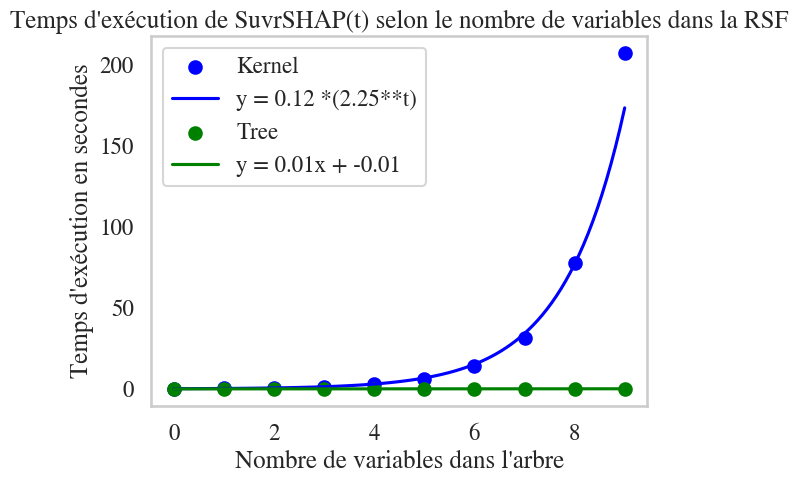

In [ ]:
graph_var(10)

# Scalabilité

In [ ]:
X, y = load_whas500()
X = X.astype(float)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
rsf = RandomSurvivalForest(random_state=42).fit(X_train, y_train)

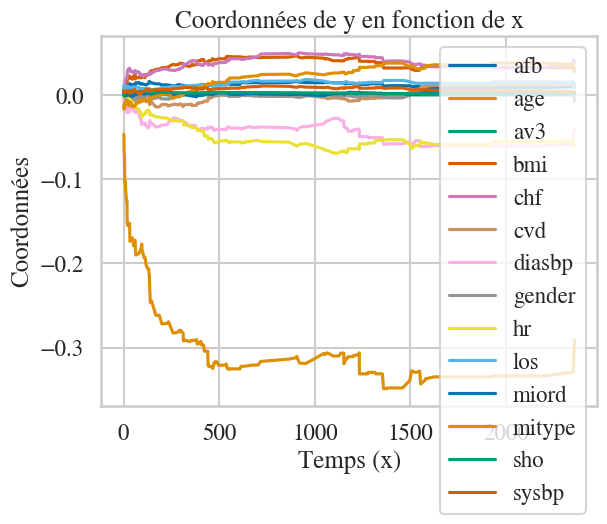

In [ ]:
unique_times = rsf.estimators_[0].unique_times_
x = np.array(unique_times)
y = np.array([
    TreeExplainer(rsf,t=i).shap_values(X_test.iloc[4, :])[:-1]
    for i in range(len(unique_times))
    ])
plt.plot(x,y,label=X.columns)

# Ajouter des labels et une légende
plt.xlabel("Temps (x)")
plt.ylabel("Coordonnées")
plt.title("Coordonnées de y en fonction de x")
plt.legend()

# Afficher le graphique
plt.show()

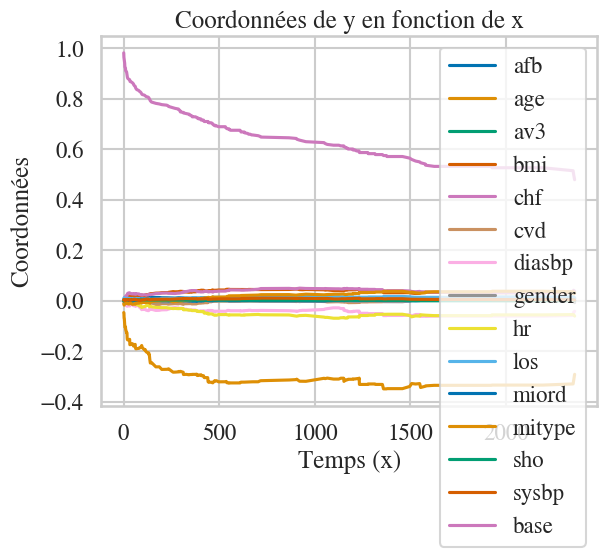

In [ ]:
unique_times = rsf.estimators_[0].unique_times_
x = np.array(unique_times)
y = np.array([
    TreeExplainer(rsf,t=i).shap_values(X_test.iloc[4, :])
    for i in range(len(unique_times))
    ])
plt.plot(x,y,label=list(X.columns)+["base"])

# Ajouter des labels et une légende
plt.xlabel("Temps (x)")
plt.ylabel("Coordonnées")
plt.title("Coordonnées de y en fonction de x")
plt.legend()

# Afficher le graphique
plt.show()

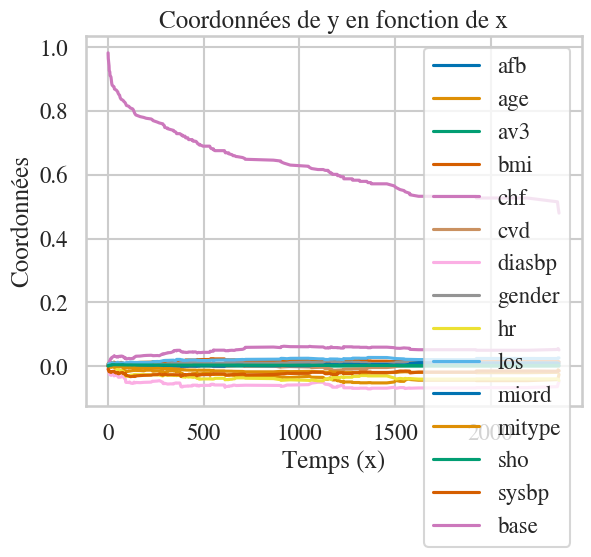

In [ ]:
unique_times = rsf.estimators_[0].unique_times_
x = np.array(unique_times)
y = np.array([
    TreeExplainer(rsf,t=i).shap_values(X_test.iloc[1, :])
    for i in range(len(unique_times))
    ])
plt.plot(x,y,label=list(X.columns)+["base"])

# Ajouter des labels et une légende
plt.xlabel("Temps (x)")
plt.ylabel("Coordonnées")
plt.title("Coordonnées de y en fonction de x")
plt.legend()

# Afficher le graphique
plt.show()

## Essais données simulées

In [ ]:
import numpy as np
import pandas as pd
from sklearn.datasets import make_classification

# Générer 500 patients avec 50 covariables
X, y = make_classification(n_samples=500, n_features=50, random_state=42)

# Simuler des temps de survie et des événements censurés
np.random.seed(42)
survival_time = np.random.exponential(scale=365, size=500)  # Temps aléatoires (jours)
event_observed = np.random.choice([1, 0], size=500)  # Événements observés (1) ou censurés (0)

# Convertir en DataFrame
df = pd.DataFrame(X, columns=[f"covariate_{i}" for i in range(X.shape[1])])
df["time"] = survival_time
df["event"] = event_observed

print(df.head())

   covariate_0  covariate_1  covariate_2  covariate_3  covariate_4  \
0     0.221811     0.357821     1.136227     1.862896     1.761403   
1     0.280636    -1.137686    -1.344705     1.455822    -1.189667   
2    -0.361463     1.590582    -0.125711    -0.165631     1.796361   
3     1.451927     0.461331     0.495751    -0.967752     0.021713   
4    -0.622731    -1.242420     1.019313    -0.054746     0.822342   

   covariate_5  covariate_6  covariate_7  covariate_8  covariate_9  ...  \
0     0.780214     0.023621     1.652079     1.423631     0.028907  ...   
1     0.619711     0.058023    -1.416528     1.237438    -0.624345  ...   
2    -0.148969     0.834751    -0.173507    -0.002404     0.706079  ...   
3    -0.253087     1.604935     0.592041     0.171187    -0.591147  ...   
4    -1.312661     0.742210     1.597211    -0.453353     0.698399  ...   

   covariate_42  covariate_43  covariate_44  covariate_45  covariate_46  \
0      0.659574     -1.940430     -1.212715     -0.82

In [ ]:
from sksurv.util import Surv

# Convertir la colonne (time, event) au bon format
y = Surv.from_arrays(event=df["event"], time=df["time"].values)

# Séparer les covariables (X)
X = df.drop(columns=["time", "event"])
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [ ]:
rsf = RandomSurvivalForest(n_estimators=100, min_samples_split=10, random_state=42)
rsf.fit(X, y)

RandomSurvivalForest(min_samples_split=10, random_state=42)

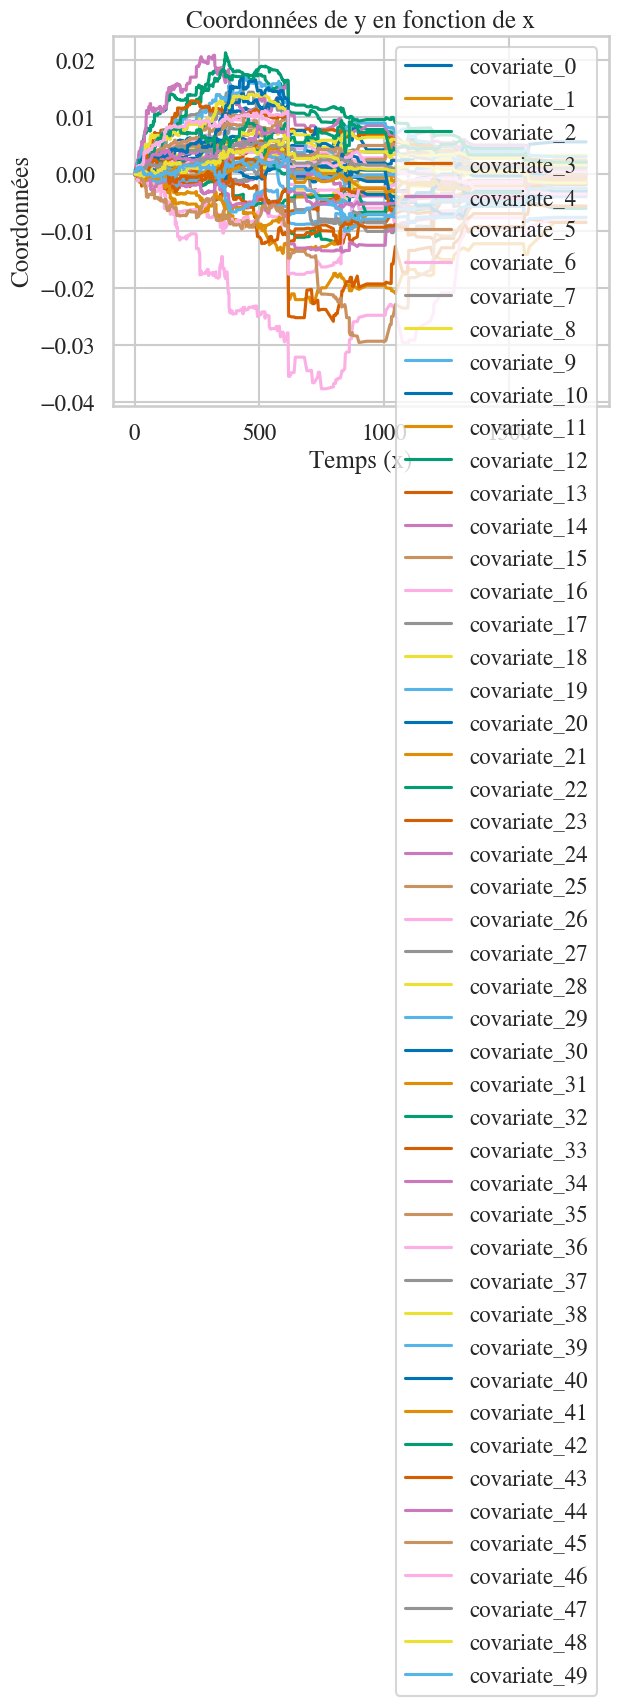

In [ ]:
unique_times = rsf.estimators_[0].unique_times_
x = np.array(unique_times)
y = np.array([
    TreeExplainer(rsf,t=i).shap_values(X_test.iloc[1, :])[:-1]
    for i in range(len(unique_times))
    ])
plt.plot(x,y,label=X.columns)

# Ajouter des labels et une légende
plt.xlabel("Temps (x)")
plt.ylabel("Coordonnées")
plt.title("Coordonnées de y en fonction de x")
plt.legend()

# Afficher le graphique
plt.show()

# Junk et tests

In [ ]:
print("arbre 0, feuille 0")
print(rsf.estimators_[0].tree_.value[0][:5])
print("arbre 1, feuille 0")
print(rsf.estimators_[1].tree_.value[0][:5])
print("arbre 0, feuille 1")
print(rsf.estimators_[0].tree_.value[1][:5])
print("arbre 1, feuille 1")
print(rsf.estimators_[1].tree_.value[1][:5])

arbre 0, feuille 0
[[0.002      0.998     ]
 [0.002      0.998     ]
 [0.002      0.998     ]
 [0.002      0.998     ]
 [0.00401207 0.996     ]]
arbre 1, feuille 0
[[0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]]
arbre 0, feuille 1
[[0.00425532 0.99574468]
 [0.00425532 0.99574468]
 [0.00425532 0.99574468]
 [0.00425532 0.99574468]
 [0.00425532 0.99574468]]
arbre 1, feuille 1
[[0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]]


In [ ]:
rsf.estimators_[0].unique_times_

array([   1.85216952,    2.02115844,    2.54638935,    3.37245605,
          3.97733441,    4.16778514,    4.46356469,    5.2917991 ,
          5.68572011,    6.10533586,    6.71230906,    7.59174742,
          8.59465616,    8.98501559,    9.37232748,    9.39793751,
          9.80721152,   11.30589767,   11.65579367,   12.77270833,
         13.36049804,   13.71833438,   13.89317724,   15.17722995,
         15.19486232,   16.1034345 ,   16.89291748,   16.92224827,
         16.97668354,   17.18944759,   17.36080516,   19.29064689,
         19.36876001,   21.15190734,   21.63782285,   21.84115054,
         23.96884402,   24.55133477,   26.23771669,   26.71158923,
         26.95511384,   27.57432268,   27.98140222,   28.07918191,
         28.27869212,   29.23806167,   29.53663382,   29.82238653,
         30.96979396,   31.8258077 ,   32.06726541,   32.08048006,
         32.35866174,   32.56202558,   33.81924252,   34.53964297,
         34.90748549,   34.93984785,   35.67004127,   35.90032

In [ ]:
X_test.iloc[0,:]

covariate_0    -0.558816
covariate_1    -0.469958
covariate_2    -0.703951
covariate_3    -0.870163
covariate_4    -0.423437
covariate_5    -0.421103
covariate_6    -0.399823
covariate_7     0.067274
covariate_8    -0.015688
covariate_9    -0.737262
covariate_10   -2.225935
covariate_11    1.601899
covariate_12   -0.489944
covariate_13   -0.611768
covariate_14   -1.268751
covariate_15   -0.787551
covariate_16    2.277689
covariate_17   -0.561661
covariate_18    0.254361
covariate_19   -0.513800
covariate_20    0.543654
covariate_21   -2.679984
covariate_22    0.386025
covariate_23   -0.667942
covariate_24   -0.293567
covariate_25    1.372750
covariate_26    0.901112
covariate_27   -0.588692
covariate_28   -2.550026
covariate_29   -2.600135
covariate_30   -1.491228
covariate_31    0.344775
covariate_32   -0.099551
covariate_33    1.832120
covariate_34    0.668964
covariate_35   -2.161056
covariate_36   -0.078387
covariate_37    0.919408
covariate_38   -0.620023
covariate_39    0.467575


In [ ]:
rsf.predict_survival_function( X_test.iloc[:2,:], return_array=False)

array([StepFunction(x=array([   1.85216952,    2.02115844,    2.54638935,    3.37245605,
                 3.97733441,    4.16778514,    4.46356469,    5.2917991 ,
                 5.68572011,    6.10533586,    6.71230906,    7.59174742,
                 8.59465616,    8.98501559,    9.37232748,    9.39793751,
                 9.80721152,   11.30589767,   11.65579367,   12.77270833,
                13.36049804,   13.71833438,   13.89317724,   15.17722995,
                15.19486232,   16.1034345 ,   16.89291748,   16.92224827,
                16.97668354,   17.18944759,   17.36080516,   19.29064689,
                19.36876001,   21.15190734,   21.63782285,   21.84115054,
                23.96884402,   24.55133477,   26.23771669,   26.71158923,
                26.95511384,   27.57432268,   27.98140222,   28.07918191,
                28.27869212,   29.23806167,   29.53663382,   29.82238653,
                30.96979396,   31.8258077 ,   32.06726541,   32.08048006,
                32.3586

In [ ]:
rsf.estimators_[0].tree_.predict(X_test.iloc[:2,:].astype(np.float32).to_numpy())

array([[[0.        , 1.        ],
        [0.        , 1.        ],
        [0.        , 1.        ],
        ...,
        [1.        , 0.        ],
        [1.        , 0.        ],
        [1.        , 0.        ]],

       [[0.        , 1.        ],
        [0.        , 1.        ],
        [0.        , 1.        ],
        ...,
        [1.66666667, 0.        ],
        [1.66666667, 0.        ],
        [1.66666667, 0.        ]]])

In [ ]:
rsf.estimators_[0].tree_.predict(X_test.iloc[:2,:].astype(np.float32).to_numpy())[...,0]

array([[0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.  